# Analysis of the BR policies

In this notebook we explore the performance of BR policies trained on two different populations, `P0` and `P1`.

TODOS:
1. [X] Plot performance of BR policies on train and test sets
2. [X] Calculate and plot generalization gap of BR policies
    - [ ] Try normalizing by the performance of the best policy
3. [X] Calculate and plot the diversity of each policy population
4. [X] Look at policy diversity in the context of the generalization gap
5. [x] Look at different functions of diversity


Progress:
- There is a clear generalization gap for the BR policies for each environment, with some minor exceptions
- The relationship between diversity and generalization gap is not clear. It's complicated. I hypothesize there are a two key factors: (1) population diversity, (2) population fitness, but how they affect generalization is not clear. I need to think about this more.



In [92]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from posggym_baselines.config import REPO_DIR

sns.set_theme()
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")

SAVE_RESULTS = False

In [132]:
PURSUITEVASION_POLICY_NAMES = {
    0: {
        "P0": [f"KLR{i}_i0" for i in list(range(5)) + ["BR"]],
        "P1": [f"RL{i+1}_i0" for i in range(6)]
    }, 
    1: {
        "P0": [f"KLR{i}_i1" for i in list(range(5)) + ["BR"]],
        "P1": [f"RL{i+1}_i1" for i in range(6)]
    },
}

ENV_DATA_DIR = REPO_DIR / 'baseline_exps' / 'env_data'
ENV_DATA = {}
env_ids = ENV_DATA_DIR.glob("*")
env_ids.sort()
for env_id in env_ids:
    env_data = {
        "env_dir": ENV_DATA_DIR / env_id,
        "br_results_file": ENV_DATA_DIR / env_id / "br_results.csv",
        "div_results_file": ENV_DATA_DIR / env_id / "div_results.csv",
    }
    env_kwargs_file = ENV_DATA_DIR / env_id / "env_kwargs.yaml"
    with open(env_kwargs_file, "r") as f:
        env_data["env_kwargs"] = yaml.safe_load(f)

    env_id_tokens = env_id.split("_")
    if len(env_id_tokens) == 1:
        agent_id_suffix = ""
        env_data["agent_id"] = None
    else:
        agent_id_suffix = "_" + env_id_tokens[1]
        env_data["co_agent_id"] = int(env_id_tokens[1][1:])
        env_data["agent_id"] = (env_data["co_agent_id"] + 1) % 2

    with open(ENV_DATA_DIR / env_id / f"agents_P0{agent_id_suffix}.yaml", "r") as f:
        env_data["agents_P0"] = yaml.safe_load(f)
    assert len(env_data["agents_P0"]) == 1

    with open(ENV_DATA_DIR / env_id / f"agents_P1{agent_id_suffix}.yaml", "r") as f:
        env_data["agents_P1"] = yaml.safe_load(f)
    assert len(env_data["agents_P1"]) == 1
    
    if env_id == "PursuitEvasion-v1_i0":
        for pop_id in ["P0", "P1"]:
            env_data[f"agent_names_{pop_id}"] = PURSUITEVASION_POLICY_NAMES[1][pop_id]
            env_data[f"co_team_names_{pop_id}"] = PURSUITEVASION_POLICY_NAMES[0][pop_id]
    elif env_id == "PursuitEvasion-v1_i1":
        for pop_id in ["P0", "P1"]:
            env_data[f"agent_names_{pop_id}"] = PURSUITEVASION_POLICY_NAMES[0][pop_id]
            env_data[f"co_team_names_{pop_id}"] = PURSUITEVASION_POLICY_NAMES[1][pop_id]
    else:
        for pop_id in ["P0", "P1"]:
            policy_ids = list(env_data[f"agents_{pop_id}"].values())[0]
            policy_names = []
            for policy_id in policy_ids:
                policy_name = policy_id.split("/")[-1].split("-v")[0]
                policy_names.append(policy_name)

            env_data[f"agent_names_{pop_id}"] = policy_names
            env_data[f"co_team_names_{pop_id}"] = policy_names

    # env_data["br_results"] = pd.read_csv(env_data["br_results_file"])
    # env_data["div_results"] = pd.read_csv(env_data["div_results_file"])
    ENV_DATA[env_id] = env_data

NUM_ENVS = len(ENV_DATA)

# figure parameters
FIGSIZE = (10, 10)
N_COLS = min(3, NUM_ENVS)
N_ROWS = (NUM_ENVS // N_COLS) + int(NUM_ENVS % N_COLS > 0)

## BR Policy Performance against Train and Test populations

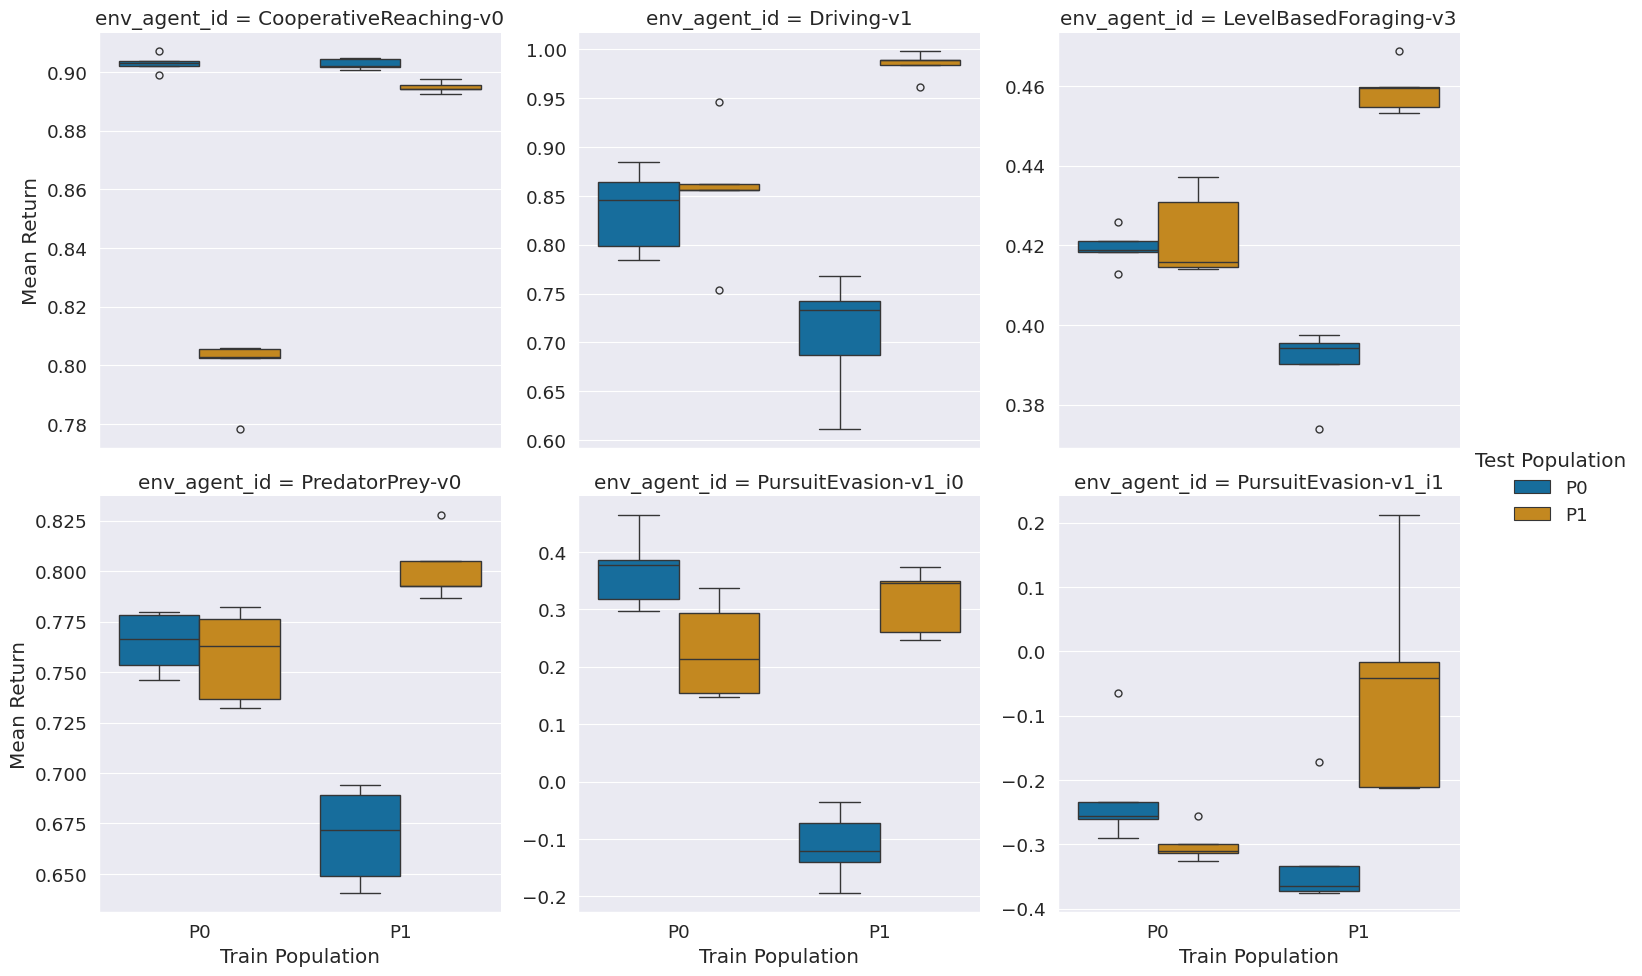

In [133]:
br_results = []
for env_id, env_data in ENV_DATA.items():
    env_br_results = pd.read_csv(env_data["br_results_file"])
    env_br_results["env_agent_id"] = env_id
    br_results.append(env_br_results)

br_results = pd.concat(br_results)
br_results.rename(
    columns={
        "train_pop": "Train Population",
        "eval_pop": "Test Population",
        "mean_returns": "Mean Return",
    },
    inplace=True,
)
br_results.sort_values(by=["env_agent_id", "Train Population", "Test Population"], inplace=True)


br_plot = sns.catplot(
    data=br_results,
    x="Train Population",
    y="Mean Return",
    hue="Test Population",
    col="env_agent_id",
    col_wrap=N_COLS,
    kind="box",
    sharey=False,
)

if SAVE_RESULTS:
    br_plot.figure.savefig(
        ENV_DATA_DIR / "br_results.png", bbox_inches="tight"
    )

## BR Policy Generalization Gap

The generalization gap of the BR Policy is the difference in performance between the train and test populations. We calculate this by taking the difference between the mean performance of the train and test populations.

Specifically, for each seed, we calculate the mean performance of the train and test populations. Then, we take the difference between the two means. Finally, we take the mean of the differences across all seeds.

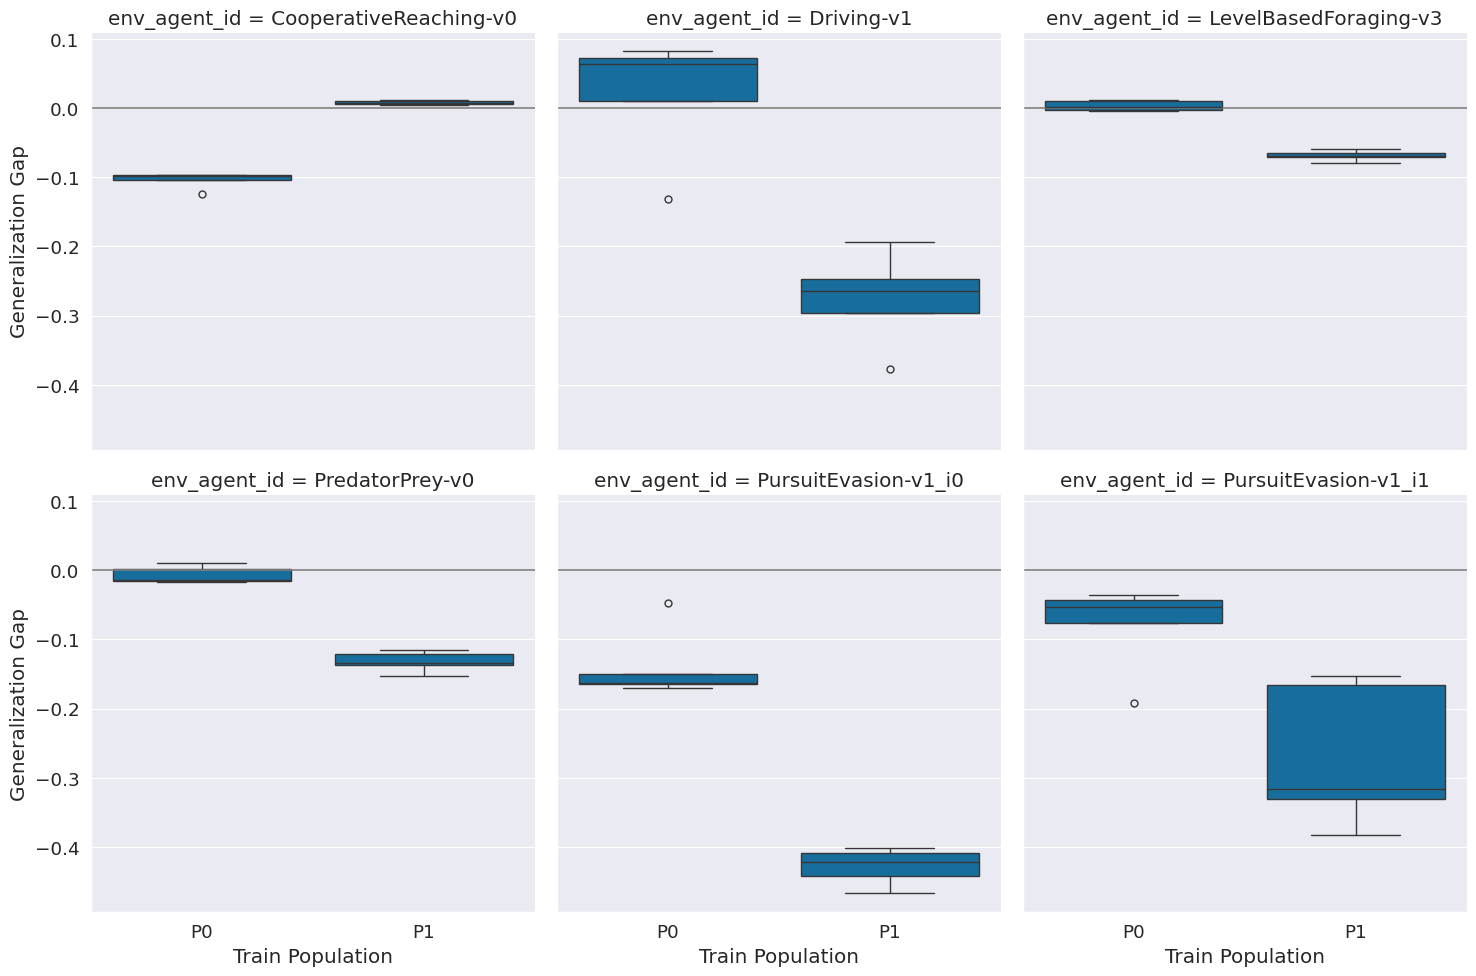

In [134]:
gg_results = []
for env_id, env_data in ENV_DATA.items():
    env_br_results = pd.read_csv(env_data["br_results_file"])
    env_br_results["env_agent_id"] = env_id
    
    gg_results.append(env_br_results)

gg_results = pd.concat(gg_results)
gg_results.rename(
    columns={
        "train_pop": "Train Population",
        "eval_pop": "Test Population",
        "mean_returns": "Mean Return",
    },
    inplace=True,
)
gg_results.sort_values(by=["env_agent_id", "Train Population", "Test Population"], inplace=True)

gg_results["train"] = gg_results.apply(lambda row: row["Train Population"] == row["Test Population"], axis=1)

gg_df = gg_results[
    gg_results["train"] == True  # noqa: E712
].merge(
    gg_results[gg_results["train"] == False],    # noqa: E712
    on=["env_id", "env_agent_id", "train_seed", "Train Population"],
    suffixes=("", "_test"),
)

gg_df["Generalization Gap"] = gg_df["Mean Return_test"] - gg_df["Mean Return"]

gg_plot = sns.catplot(
    data=gg_df,
    x="Train Population",
    y="Generalization Gap",
    col="env_agent_id",
    col_wrap=N_COLS,
    kind="box",
    sharey=True,
)
gg_plot.refline(x=None, y=0.0, linestyle="-")

## Population Diversity

We calculate the diversity of a population of policies by taking the mean of the pairwise distances between the returns of all policies in the population. We use the Euclidean distance as our distance metric.

In [135]:
def policy_pop_id(row, env_id):
    if row["policy_name"] in ENV_DATA[env_id]["agent_names_P0"]:
        return "P0"
    if row["policy_name"] in ENV_DATA[env_id]["agent_names_P1"]:
        return "P1"
    # not used in exps
    return "P2"

def co_team_name(row):
    co_team_id = row["co_team_id"].replace("(", "").replace(")", "")
    return co_team_id

def co_team_pop_id(row, env_id):
    if row["co_team_name"] in ENV_DATA[env_id]["co_team_names_P0"]:
        return "P0"
    if row["co_team_name"] in ENV_DATA[env_id]["co_team_names_P1"]:
        return "P1"
    # not used in exps
    return "P2"

div_results = []
for env_id, env_data in ENV_DATA.items():
    env_div_results = pd.read_csv(env_data["div_results_file"])
    env_div_results["env_agent_id"] = env_id
    # drop "Random-v0" policy
    env_div_results = env_div_results[env_div_results["policy_id"] != "Random-v0"]
    env_div_results = env_div_results[env_div_results["co_team_id"] != "(Random)"]
    
    env_div_results["co_team_name"] = env_div_results.apply(lambda row: co_team_name(row), axis=1)
    env_div_results["policy_pop_id"] = env_div_results.apply(lambda row: policy_pop_id(row, env_id), axis=1)
    env_div_results["co_team_pop_id"] = env_div_results.apply(lambda row: co_team_pop_id(row, env_id), axis=1)

    # drop unused rows
    env_div_results = env_div_results[env_div_results["policy_pop_id"] != "P2"]
    env_div_results = env_div_results[env_div_results["co_team_pop_id"] != "P2"]

    # average over any duplicate rows
    env_div_results = env_div_results.groupby([
        "env_id",
        "env_agent_id", 
        "policy_name",
        "co_team_name",
        "policy_pop_id", 
        "co_team_pop_id",
        "agent_id",
    ]).agg(
        {"episode_reward_mean": "mean"}
    ).reset_index()

    div_results.append(env_div_results)

div_results = pd.concat(div_results)

CooperativeReaching-v0 0
Driving-v1 0
LevelBasedForaging-v3 0
PredatorPrey-v0 0
PursuitEvasion-v1_i0 1
PursuitEvasion-v1_i1 0


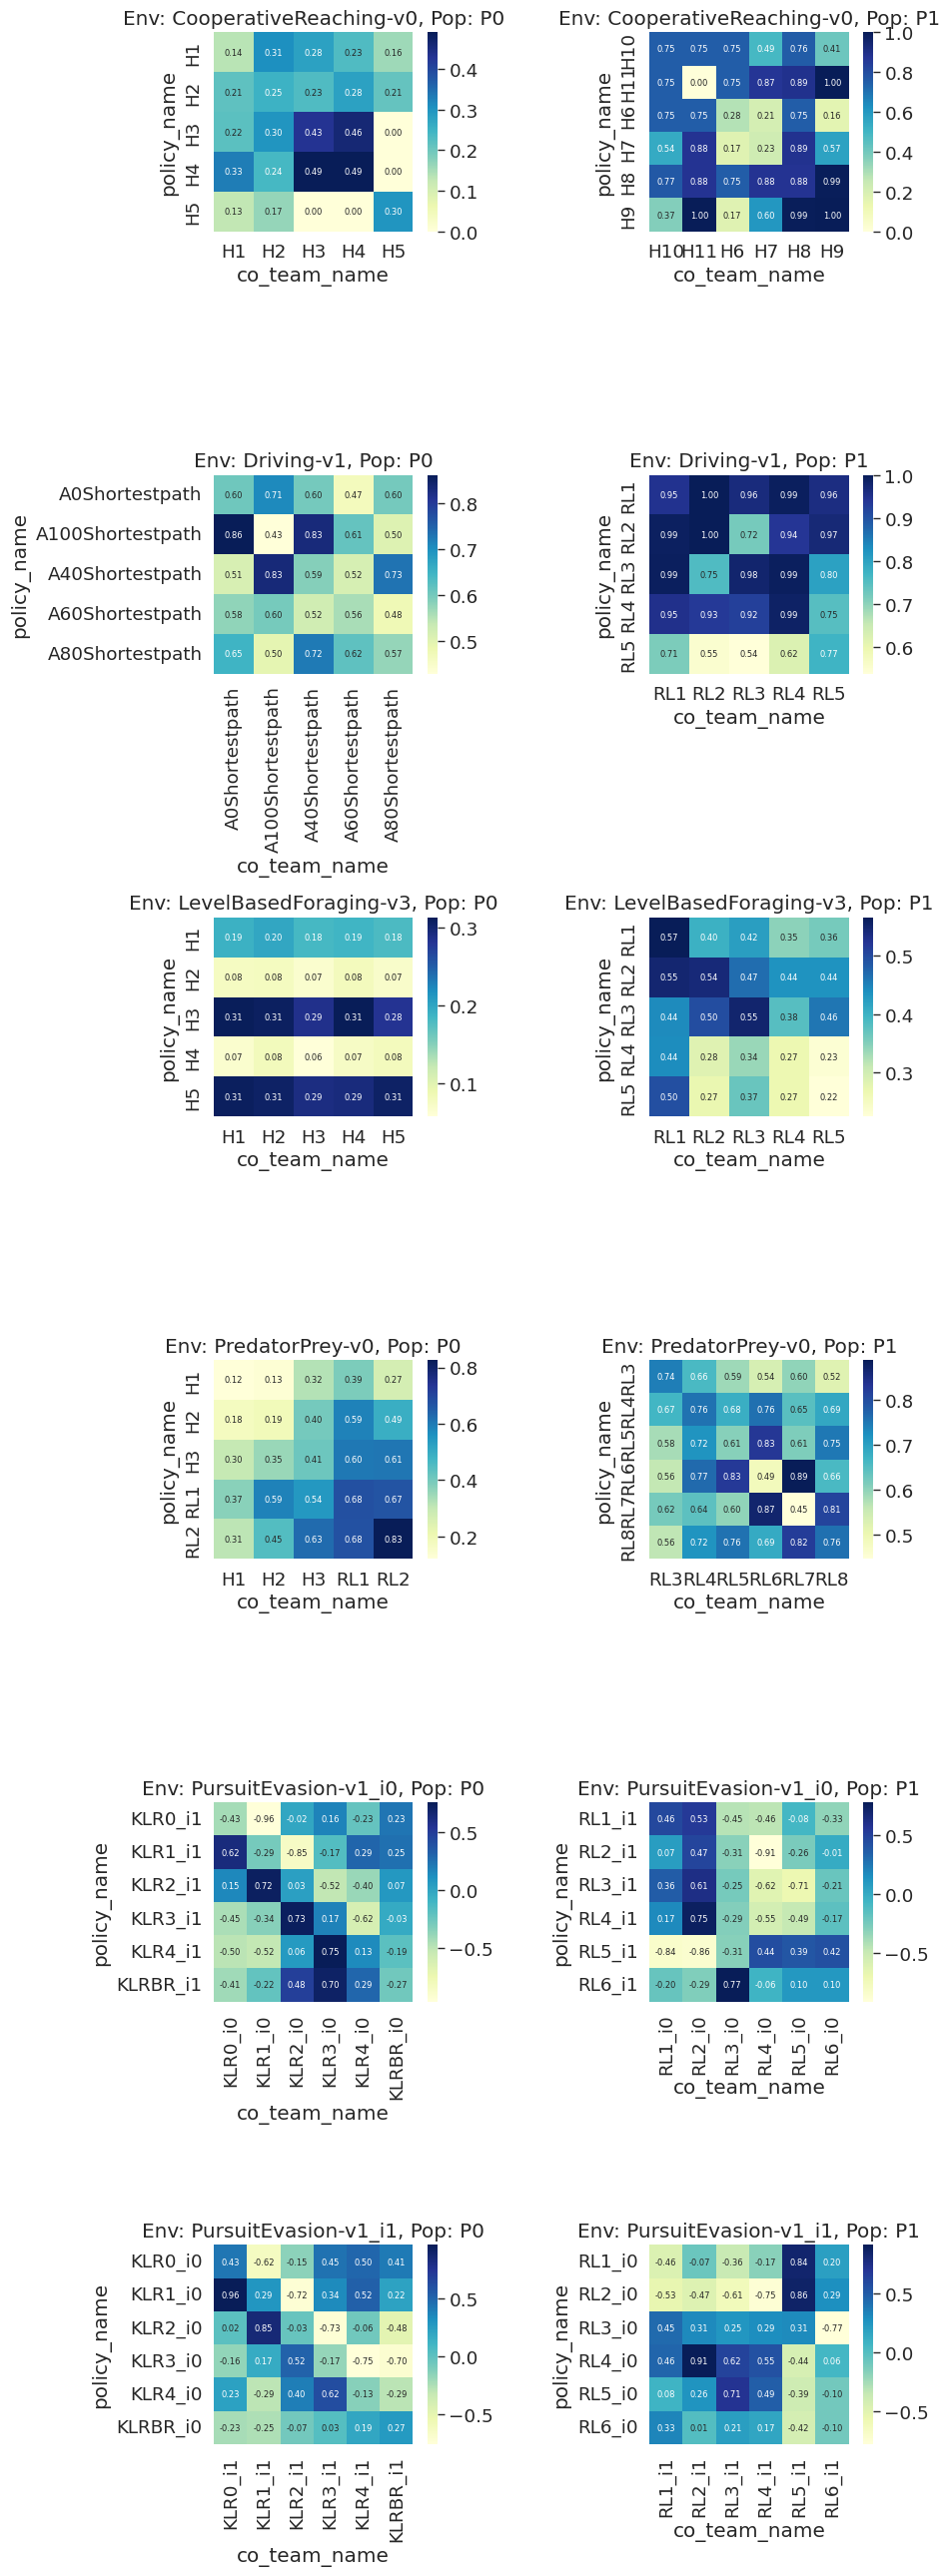

In [136]:
fig, axes = plt.subplots(nrows=NUM_ENVS, ncols=2, figsize=(10, (NUM_ENVS * 4) + 2))

for row, (env_id, env_data) in enumerate(ENV_DATA.items()):
    agent_id = 0 if env_data["agent_id"] is None else env_data["agent_id"]
    print(env_id, agent_id)
    for col, pop_id in enumerate(["P0", "P1"]):
        env_df = div_results[
            (div_results["env_agent_id"] == env_id) &
            (div_results["agent_id"] == agent_id) &
            (div_results["policy_pop_id"] == pop_id) &
            (div_results["co_team_pop_id"] == pop_id)
        ]
        pw_returns = env_df.pivot(index="policy_name", columns="co_team_name", values="episode_reward_mean")
        sns.heatmap(
            data=pw_returns,
            ax=axes[row, col],
            annot=True,
            cmap="YlGnBu",
            fmt=".2f",
            square=True,
            annot_kws={"fontsize": 6}
        )
        axes[row, col].set_title(f"Env: {env_id}, Pop: {pop_id}")

fig.tight_layout()


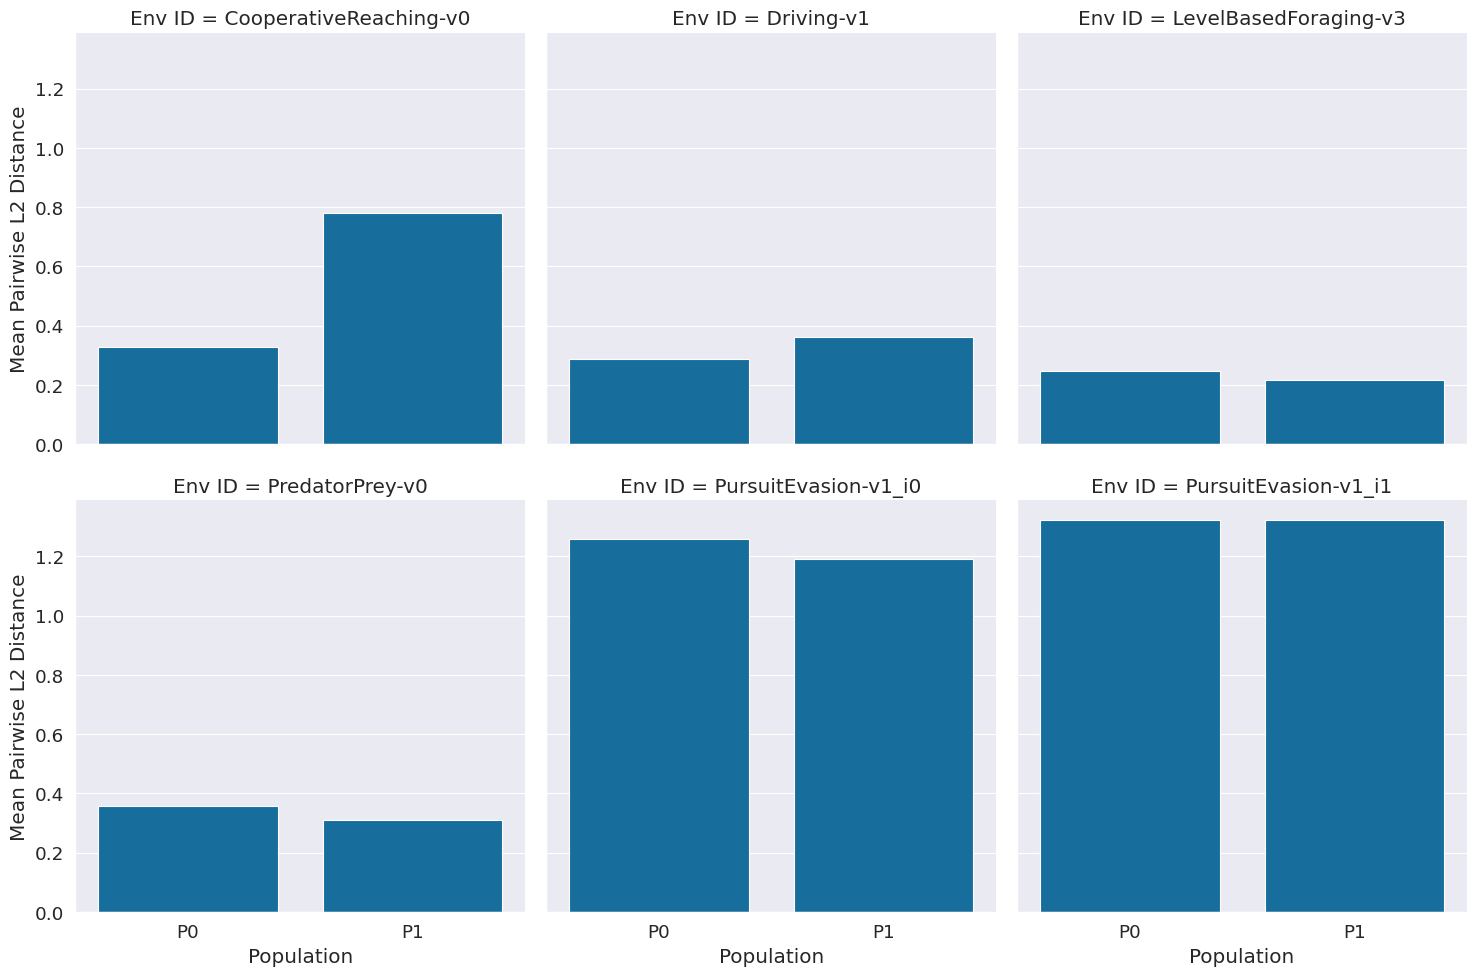

In [155]:
# fig, axes = plt.subplots(nrows=NUM_ENVS, ncols=2, figsize=(10, (NUM_ENVS * 4) + 2))

cols = ["Env ID", "Population", "Mean Pairwise L2 Distance", "Mean Pairwise Return"]
pop_div_results = []
for row, (env_id, env_data) in enumerate(ENV_DATA.items()):
    agent_id = 0 if env_data["agent_id"] is None else env_data["agent_id"]
    for col, pop_id in enumerate(["P0", "P1"]):
        pop_pw_df = div_results[
            (div_results["env_agent_id"] == env_id) &
            (div_results["agent_id"] == agent_id) &
            (div_results["policy_pop_id"] == pop_id) &
            (div_results["co_team_pop_id"] == pop_id)
        ].pivot(index="co_team_name", columns="policy_name", values="episode_reward_mean")
        pw_ed = np.zeros((pop_pw_df.shape[0], pop_pw_df.shape[0]))
        pw_returns = np.zeros((pop_pw_df.shape[0], pop_pw_df.shape[0]))
        for i, pi_i in enumerate(pop_pw_df):
            pw_returns[i] = pop_pw_df[pi_i]
            for j, pi_j in enumerate(pop_pw_df):
                pw_ed[i, j] = np.sqrt(np.sum((pop_pw_df[pi_i] - pop_pw_df[pi_j])**2))

        pop_div_results.append([env_id, pop_id, np.mean(pw_ed), np.mean(pw_returns)])

pop_div_results = pd.DataFrame(columns=cols, data=pop_div_results)
div_plot = sns.catplot(
    data=pop_div_results,
    x="Population",
    y="Mean Pairwise L2 Distance",
    col="Env ID",
    col_wrap=N_COLS,
    kind="bar",
    sharey=True,
)

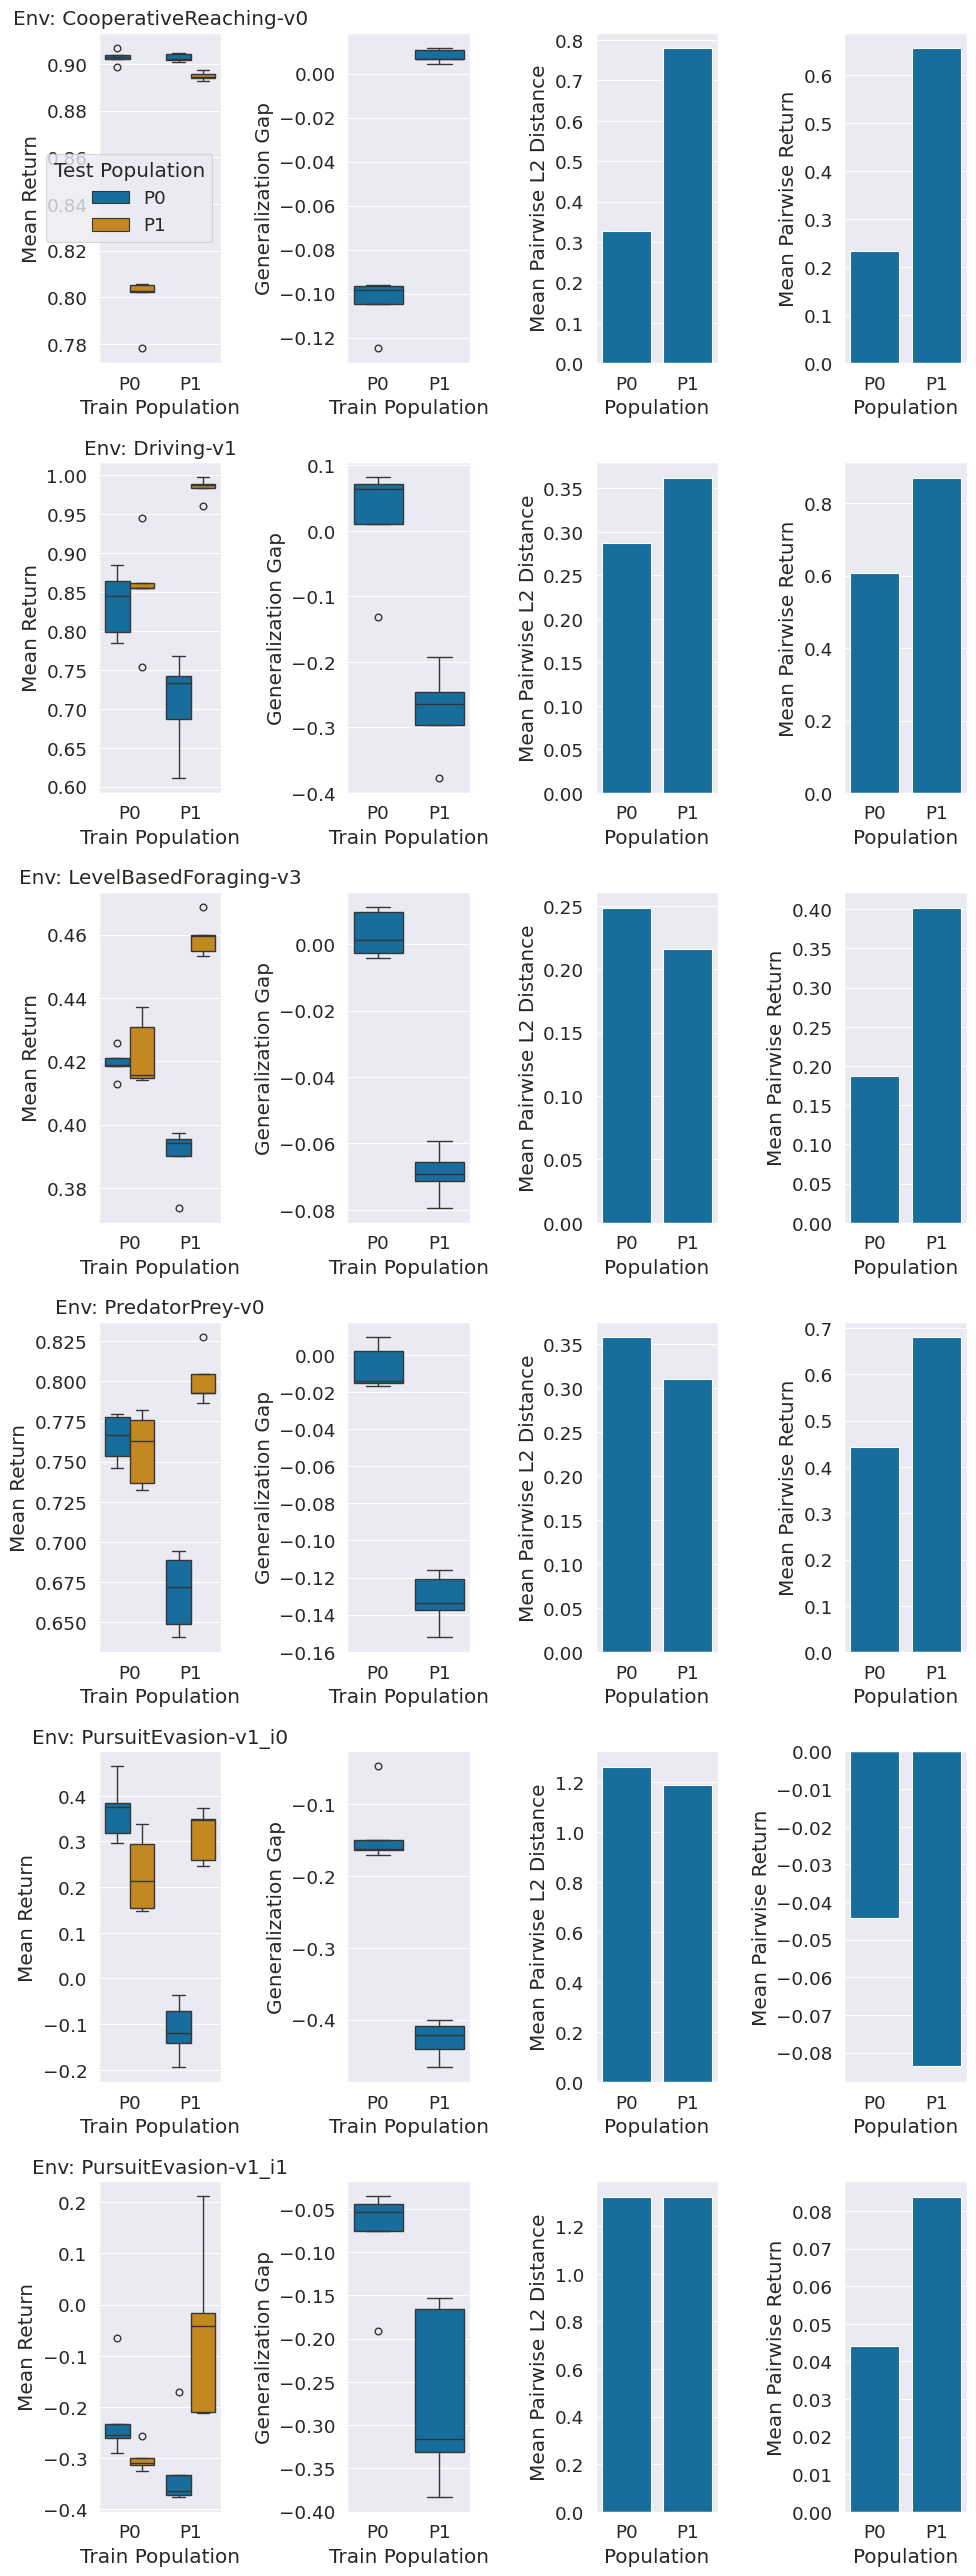

In [156]:
fig, axs = plt.subplots(nrows=NUM_ENVS, ncols=4, figsize=(10, (NUM_ENVS * 4) + 2))

env_ids = list(ENV_DATA.keys())
env_ids.sort()
for row, env_id in enumerate(env_ids):
    env_br_plot = sns.boxplot(
        data=br_results[br_results["env_agent_id"] == env_id],
        x="Train Population",
        y="Mean Return",
        hue="Test Population",
        ax=axs[row, 0],
        legend=row==0
    )

    env_gg_plot = sns.boxplot(
        data=gg_df[gg_df["env_agent_id"] == env_id],
        x="Train Population",
        y="Generalization Gap",
        ax=axs[row, 1],
    )

    div_plot = sns.barplot(
        data=pop_div_results[pop_div_results["Env ID"] == env_id],
        x="Population",
        y="Mean Pairwise L2 Distance",
        ax=axs[row, 2],
    )
    div_plot = sns.barplot(
        data=pop_div_results[pop_div_results["Env ID"] == env_id],
        x="Population",
        y="Mean Pairwise Return",
        ax=axs[row, 3],
    )
    axs[row, 0].set_title(f"Env: {env_id}")

fig.tight_layout()

,env_agent_id,Train Population,Test Population,Mean Return,Train,Test Population_test,Mean Return_test,Train_test,Generalization Gap,Mean Pairwise L2 Distance,Mean Pairwise Return
0,CooperativeReaching-v0,P0,P0,0.902977,True,P1,0.798837,False,-0.104139,0.327204,0.234000
1,CooperativeReaching-v0,P1,P1,0.894823,True,P0,0.902772,False,0.007949,0.779210,0.656042
2,Driving-v1,P0,P0,0.835144,True,P1,0.854353,False,0.019209,0.286838,0.607818
3,Driving-v1,P1,P1,0.983825,True,P0,0.708546,False,-0.275278,0.361742,0.869721
4,LevelBasedForaging-v3,P0,P0,0.419423,True,P1,0.422541,False,0.003118,0.248455,0.187005
5,LevelBasedForaging-v3,P1,P1,0.459174,True,P0,0.390255,False,-0.068920,0.216120,0.401863
6,PredatorPrey-v0,P0,P0,0.764828,True,P1,0.758060,False,-0.006768,0.357677,0.443333
7,PredatorPrey-v0,P1,P1,0.800889,True,P0,0.668929,False,-0.131960,0.310072,0.679167


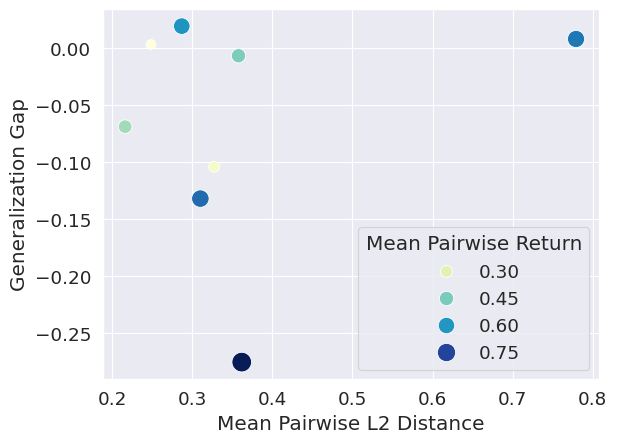

In [169]:
# Plot all features together
# x = "Mean Pairwise L2 Distance"
# y = "Generalization Gap"
# hue/z = "Mean Pairwise Return"

# Get BR results averaged across seeds
all_df = br_results.groupby(
    ["env_agent_id", "Train Population", "Test Population"]
).agg(
    {"Mean Return": "mean"}
).reset_index()

all_df.sort_values(by=["env_agent_id", "Train Population", "Test Population"], inplace=True)

all_df["Train"] = all_df.apply(lambda row: row["Train Population"] == row["Test Population"], axis=1)


pop_df = all_df[
    all_df["Train"] == True  # noqa: E712
].merge(
    all_df[all_df["Train"] == False],    # noqa: E712
    on=["env_agent_id", "Train Population"],
    suffixes=("", "_test"),
)
pop_df["Generalization Gap"] = pop_df["Mean Return_test"] - pop_df["Mean Return"]
# pop_df

div_df = pop_div_results[
    ["Env ID", "Population", "Mean Pairwise L2 Distance", "Mean Pairwise Return"]
].copy()

pop_df = pop_df.merge(
    div_df,
    left_on=["env_agent_id", "Train Population"],
    right_on=["Env ID", "Population"],
    suffixes=("", "_div"),
)
pop_df.drop(columns=["Env ID", "Population"], inplace=True)

# drop PursuitEvasion-v1_i0 and PursuitEvasion-v1_i1
pop_df = pop_df[pop_df["env_agent_id"] != "PursuitEvasion-v1_i0"]
pop_df = pop_df[pop_df["env_agent_id"] != "PursuitEvasion-v1_i1"]

sns.scatterplot(
    data=pop_df,
    x="Mean Pairwise L2 Distance",
    y="Generalization Gap",
    hue="Mean Pairwise Return",
    palette="YlGnBu",
    size="Mean Pairwise Return",
    sizes=(50, 200),
)

pop_df
